# Predicting IT Service Ticket Reassingnment Using RGCN (DGL)

<a href="https://colab.research.google.com/github/arangoml/networkx-adapter/blob/master/examples/ITSM_ArangoDB_Adapter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides the details of applying a __Graph Convolutional Network(GCN)__ to predict if an IT service ticket will be reassigned. The workflow associated with ticket resolution has a convinient graph representation. The raw data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Incident+management+process+enriched+event+log) is loaded into ArangoDB using the [ITSM_data_loader python file](files/ITSM_data_loader.py). The [DGL](https://github.com/dmlc/dgl) library is used to create the __GCN__ model that is used to predict ticket reassignment. The graph associated with this prediction task is _heterogeneous_. This means that the graph has multiple types of vertices. In this example, the _incident_ (for which the ticket is created), the _support_org_ (the organization resolving the ticket), the _customer_ (who opened the ticket) and the _vendor_ (if the ticket is associated with an external product) are the different vertices in the graph (see [working with heterographs in DGL](https://docs.dgl.ai/en/0.4.x/tutorials/hetero/1_basics.html) for more details). Each of these vertices has attributes that are utilized in predicting the _reassignment_ status of a ticket. In this work, both the graph structure associated with a particular _incident_ and the properties associated with the vertices of the graph are used in the __GCN__. In particular, the semi-supervised model described in ["working with heterographs in DGL"](https://docs.dgl.ai/en/0.4.x/tutorials/hetero/1_basics.html), based on work by [Kipf et al.,](https://arxiv.org/abs/1703.06103) will be used here. The details of the implementaion are as follows.

## Install Required Libraries 

In [1]:
%%capture cap_out --no-stderr
!git clone -b oasis_connector --single-branch https://github.com/arangodb/interactive_tutorials.git
!git clone -b 0.0.0.2.5.3 --single-branch https://github.com/arangoml/networkx-adapter.git
!rsync -av networkx-adapter/examples/ ./ --exclude=.git
!rsync -av interactive_tutorials/ ./ --exclude=.git
!pip3 install adbnx_adapter==0.0.0.2.5.3.post1
!pip3 install networkx
!pip3 install matplotlib
!pip3 install pyarango
!pip3 install python-arango
!pip install dgl==0.4.3.post2

In [2]:
import os
os.chdir('./networkx-adapter/examples')

## Obtain an Oasis Connection 

Oasis is the __ArangoDB__ managed service database offering. We will use __Oasis__ for this work. This permits us to use __ArangoDB__ without worrying about the details of installation and set up.

In [3]:
import time
import oasis
con = oasis.getTempCredentials()
time.sleep(5)

print()
print("https://{}:{}".format(con["hostname"], con["port"]))
print("Username: " + con["username"])
print("Password: " + con["password"])
print("Database: " + con["dbName"])

Credentials expired.
Requesting new temp credentials.
Temp database ready to use.

https://d383fa0b596a.arangodb.cloud:8529
Username: TUTac5rjasxcp6gmbfa5q0lrg
Password: TUT6gmg8w1gyetzv3v6dj1iyh
Database: TUT9bax9scnr7jq4apooqhc


## Load the Data into Oasis 

The _arangorestore_ utility is used to load the database into the __Oasis__ instance.

In [4]:
!chmod -R 755 ./tools
!./tools/arangorestore -c none --server.endpoint http+ssl://{con["hostname"]}:{con["port"]} --server.username {con["username"]} --server.database {con["dbName"]} --server.password {con["password"]} --default-replication-factor 3  --input-directory "data/dgl_data_dump"

2021-12-31T17:55:16Z [193] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://d383fa0b596a.arangodb.cloud:8529'
2021-12-31T17:55:16Z [193] INFO [abeb4] {restore} Database name in source dump is 'TUThjyjglmb376tll56bgsvo'
2021-12-31T17:55:16Z [193] INFO [9b414] {restore} # Re-creating document collection 'customer'...
2021-12-31T17:55:16Z [193] INFO [9b414] {restore} # Re-creating document collection 'incident'...
2021-12-31T17:55:17Z [193] INFO [9b414] {restore} # Re-creating document collection 'support_org'...
2021-12-31T17:55:17Z [193] INFO [9b414] {restore} # Re-creating document collection 'vendor'...
2021-12-31T17:55:17Z [193] INFO [9b414] {restore} # Re-creating edge collection 'incident_customer'...
2021-12-31T17:55:18Z [193] INFO [9b414] {restore} # Re-creating edge collection 'incident_support_org'...
2021-12-31T17:55:18Z [193] INFO [9b414] {restore} # Re-creating edge collection 'incident_vendor'...
2021-12-31T17:55:18Z [193] INFO [6d69f] {restore} # Dispatched 7 job(s

## Create the ArangoDB DGL Adapter 

The __ArangoDB DGL Adapter__ will create a __dgl heterograph__ from __ArangoDB__. To create the __dgl heterograph__ we will need to provide a description of the graph that we would like to create. This is done by describing the vertices and edges of the graph using a _dictionary_ data structure. The details of the vertices and edges for this example are shown below. The __ArangoDB DGL Adapter__ specifies the details of the heterograph to __DGL__ using __Networkx__.

In [5]:
vcols = {"incident": {"D_sys_mod_count", "D_sys_mod_count", "D_reopen_count", "urgency", "incident_state",
                      "u_symptom", "impact", "contact_type", "u_priority_confirmation", "cmdb_ci",
                      "rfc", "problem_id", "caused_by", "location", "knowledge", "resolved_by",
                      "subcategory", "active", "category", "priority", "reassigned", "node_id"},
         "support_org": {"assigned_to", "assignment_group", "node_id"},
         "customer": {"opened_by", "node_id"},
         "vendor": {"vendor", "node_id"}}
ecols = {"incident_support_org": {"_from", "_to"}, "incident_customer": {"_from", "_to"},
         "incident_vendor": {"_from", "_to"}}

itsm_attributes = {'vertexCollections': vcols, 'edgeCollections': ecols}

After the graph structure has been defined, instantiate the _DGLArangoDB_Networkx_Adapter_ with connection and create the __dgl graph__ as shown below.

In [6]:
from adbnx_adapter.dgl_arangoDB_networkx_adapter import DGLArangoDB_Networkx_Adapter
itsmg = DGLArangoDB_Networkx_Adapter(con)

Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
Using backend: pytorch


In [7]:
g, labels = itsmg.create_dgl_graph(
    graph_name='ITSMGraph',  graph_attributes=itsm_attributes)

Creating DGL graph...
Loading edge data...
Loading vertex data...
Creating DGL Heterograph...
done!


## Visually Inspect the Graph

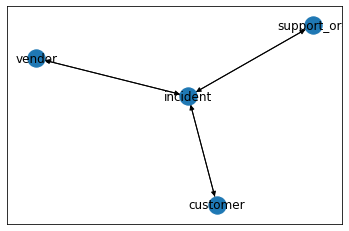

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
nx.draw_networkx(g.metagraph)

## Define the GCN 

_Note_ :Node attributes have been discretized. An embedding layer is used to generate feature representations.

In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl.function as fn


class HeteroRGCNLayer1(nn.Module):
    EMBED_SIZE = 64
    VOCAB_SIZE = 2386

    def __init__(self, hidden_size, G):
        super(HeteroRGCNLayer1, self).__init__()
        # Need an embedding layer for each node feature
        self.node_embeddings = {}
        #self.dropouts = {}
        for ntype in G.ntypes:
            # create an embedding for each feature of a node
            self.node_embeddings[ntype] = {}
            num_node_features = G.node_attr_schemes(ntype)['f'].shape[0]
            for feature in range(num_node_features):
                self.node_embeddings[ntype][feature] = nn.Embedding(
                    self.VOCAB_SIZE, self.EMBED_SIZE)
            #self.dropouts[ntype] = nn.Dropout()
        # for name in etypes:
        module_layers = {}
        for srctype, etype, dsttype in G.canonical_etypes:
            num_features = G.node_attr_schemes(srctype)['f'].shape[0]
            module_layers[etype] = nn.Linear(
                num_features * self.EMBED_SIZE, hidden_size)
        self.weight = nn.ModuleDict(module_layers)
        self.hidden_size = hidden_size

    def forward(self, G):

        funcs = {}
        for srctype, etype, dsttype in G.canonical_etypes:
            # for each node compute the embedding and store it in the graph
            # iterate over the features of each node and compute the embedding
            the_node_embedding = self.node_embeddings[srctype]
            node_feature_embeddings = []
            num_features = G.node_attr_schemes(srctype)['f'].shape[0]
            for feature in range(num_features):
                feature_embedding_layer = the_node_embedding[feature]
                node_feature_embeddings.append(feature_embedding_layer(
                    G.nodes[srctype].data['f'][:, feature]))
            comp_node_embedding = torch.cat(node_feature_embeddings, 1)
            G.nodes[srctype].data['E'] = comp_node_embedding
            # Compute W_r * h
            Wh = self.weight[etype](G.nodes[srctype].data['E'])
            #Wh = torch.sum(Wh, dim = 1)
            # Save it in graph for message passing
            G.nodes[srctype].data['Wh_%s' % etype] = Wh
            # Specify per-relation message passing functions: (message_func, reduce_func).
            # Note that the results are saved to the same destination feature 'h', which
            # hints the type wise reducer for aggregation.
            funcs[etype] = (fn.copy_u('Wh_%s' % etype, 'm'), fn.mean('m', 'h'))
        # Trigger message passing of multiple types.
        # The first argument is the message passing functions for each relation.
        # The second one is the type wise reducer, could be "sum", "max",
        # "min", "mean", "stack"
        G.multi_update_all(funcs, 'sum')
        # return G
        return {ntype: G.nodes[ntype].data['h'] for ntype in G.ntypes}


class HeteroRGCNLayer2(nn.Module):
    def __init__(self, in_size, out_size, etypes):
        super(HeteroRGCNLayer2, self).__init__()
        # W_r for each relation

        self.weight = nn.ModuleDict({
            name: nn.Linear(in_size, out_size) for name in etypes
        })

    def forward(self, G, feat_dict):
        # The input is a dictionary of node features for each type
        funcs = {}
        for srctype, etype, dsttype in G.canonical_etypes:
            # Compute W_r * h
            Wh = self.weight[etype](feat_dict[srctype])
            # Save it in graph for message passing
            G.nodes[srctype].data['Wh2_%s' % etype] = Wh
            # Specify per-relation message passing functions: (message_func, reduce_func).
            # Note that the results are saved to the same destination feature 'h', which
            # hints the type wise reducer for aggregation.
            funcs[etype] = (fn.copy_u('Wh2_%s' %
                                      etype, 'm'), fn.mean('m', 'h2'))
        # Trigger message passing of multiple types.
        # The first argument is the message passing functions for each relation.
        # The second one is the type wise reducer, could be "sum", "max",
        # "min", "mean", "stack"
        G.multi_update_all(funcs, 'sum')
        # return G
        # return the updated node feature dictionary
        return {ntype: G.nodes[ntype].data['h2'] for ntype in G.ntypes}

In [10]:
class HeteroRGCN(nn.Module):
    def __init__(self, G, hidden_size, out_size):
        super(HeteroRGCN, self).__init__()
        # create layers
        self.layer1 = HeteroRGCNLayer1(hidden_size, G)
        self.layer2 = HeteroRGCNLayer2(hidden_size, out_size, G.etypes)

    def forward(self, G):

        h_dict = self.layer1(G)
        h_dict = {k: F.leaky_relu(h) for k, h in h_dict.items()}
        h_dict = self.layer2(G, h_dict)

        # get paper logits

        return h_dict['incident']

## Create Training and Test Datasets

In [11]:
training_mask = np.random.rand(len(labels)) <= 0.8
train_idx = [i for i in range(len(labels)) if training_mask[i]]
test_idx = [i for i in range(len(labels)) if not training_mask[i]]
train_idx = torch.tensor(train_idx).long()
test_idx = torch.tensor(test_idx).long()
labels = torch.tensor(labels).long()

## Train and Evaluate the Model on Test Dataset

In [12]:
%time
# Create the model. The output has three logits for three classes.


#model = HeteroRGCN(G, 512,64, 2)

#opt = torch.optim.SGD(model.parameters(), lr=0.001)
# ,
model = HeteroRGCN(g, 32, 2)
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

model.train()

for epoch in range(100):
    opt.zero_grad()
    logits = model(g)
    # The loss is computed only for labeled nodes.
    loss = loss_fn(logits[train_idx], labels[train_idx])
    loss.backward()
    opt.step()
    pred_trng = torch.argmax(logits[train_idx], dim=1)
    res_trng = pred_trng == labels[train_idx]
    trng_acc = torch.sum(res_trng).item()/labels[train_idx].shape[0]

    pred_test = torch.argmax(logits[test_idx], dim=1)
    res_test = pred_test == labels[test_idx]
    test_acc = torch.sum(res_test).item()/labels[test_idx].shape[0]

    if epoch % 10 == 0:
        print('Loss %.4f, training accuracy %.4f, test accuracy %.4f' %
              (loss.item(), trng_acc, test_acc))

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.48 µs
Loss 0.6980, training accuracy 0.5260, test accuracy 0.5226
Loss 0.6058, training accuracy 0.6093, test accuracy 0.6120
Loss 0.5153, training accuracy 0.7644, test accuracy 0.7632
Loss 0.4469, training accuracy 0.7910, test accuracy 0.7932
Loss 0.4165, training accuracy 0.8063, test accuracy 0.8040
Loss 0.3932, training accuracy 0.8188, test accuracy 0.8167
Loss 0.3769, training accuracy 0.8254, test accuracy 0.8194
Loss 0.3648, training accuracy 0.8339, test accuracy 0.8253
Loss 0.3546, training accuracy 0.8397, test accuracy 0.8281
Loss 0.3457, training accuracy 0.8443, test accuracy 0.8291


## Note
The implementation comes with a database dump required for this exercise. If there is a need to recreate the dump, remove the existing creds.dat file and create an empty creds.dat file. The $\texttt{itsm_data_load_driver}$ can then be used to load the data to an __Oasis__ instance. The data load procedure can take about $15$ minutes to complete. Once, the data load is done, the _arangodump_ utility can be used to create a dump of the loaded data. 

In [13]:
# !rm creds.dat
# !touch creds.dat

In [ ]:
# from itsm_data_load_driver import load_ITSM_data_to_ArangoDB
# itsmdl = load_ITSM_data_to_ArangoDB()

In [ ]:
# arangodump --server.endpoint <put server address eg., http+ssl://5904e8d8a65f.arangodb.cloud:8529> --server.username <put user name>  --server.database <put dbName> --server.password <put passwd> --output-directory dgl_data_dump
